In [77]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [103]:
# preprocessing 
def preprocess(train,test):
    # test set does not have label
    train = pd.read_csv(train)
    X_test = pd.read_csv(test)
    
    X_train = train.drop('label', axis =1)
    y_train = train['label']
    
    # visualize if the targets are balanced 
    plt.figure(figsize=(10,4))
    plt.xticks(fontsize=24, rotation=0)
    plt.yticks(fontsize=24, rotation=0)
    sns.countplot(data=train, x='label')
    
   
   # reshape 28x28x1 (1 is channel for gray color)
    X_train = X_train.values.reshape(X_train.shape[0], 28, 28,1)
    X_test = X_test.values.reshape(X_test.shape[0],28,28,1)
    
    # scaling 
    X_train=X_train/255.
    X_test = X_test/255.
    
    # take validation set from train set 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=17)
    
    # One-hot encode the training labels(change the numbers to binary code )
    y_train_encode = np_utils.to_categorical(y_train)
    y_val_encode = np_utils.to_categorical(y_val)
    
    return X_train, X_val, y_train_encode, y_val_encode, X_test

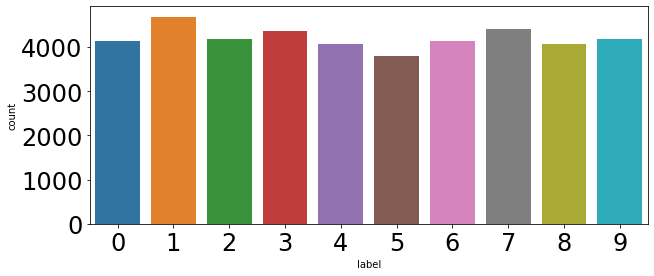

In [104]:
X_train, X_val, y_train_encode, y_val_encode = preprocess('train.csv','test_.csv')

In [111]:
print('X_train:', X_train.shape, '\nX_validation:', X_val.shape, '\nX_test:', test.shape)

X_train: (37800, 28, 28, 1) 
X_validation: (4200, 28, 28, 1) 
X_test: (28000, 28, 28, 1)


In [114]:
# normalize them to speed up learning and reduces overfitting as it adds some noise to each hidden layer’s activations
# use Xavier initialization to remain the variance the same. This helps us keep the signal from exploding to a high value or vanishing to zero
# set parameters 
batch_size = 256
epochs = 10
stride = 1 # move one pixel at a time
model = Sequential()
learning_rate=0.01
# First convolutional layer accepts image input
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu', 
                        input_shape=(28, 28, 1)))

model.add(BatchNormalization())
# Add another max pooling layer
model.add(MaxPooling2D(2))


# Add a convolutional layer
model.add(Conv2D(filters = 64, kernel_size = 5, padding='same', activation='relu'))

model.add(BatchNormalization())
# Add another max pooling layer
model.add(MaxPooling2D(2))


# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

# Summarize the model
model.summary()

# Compile the model
# used SGD+momentum(0.9)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='sgd', 
loss='categorical_crossentropy', 
metrics=['accuracy'])



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)            

In [115]:
# Train the model
history = model.fit(X_train, y_train_encode,
                    validation_data=(X_val, y_val_encode),epochs =epochs, batch_size = batch_size)

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 100s 3ms/step - loss: 0.3309 - accuracy: 0.9124 - val_loss: 2.1488 - val_accuracy: 0.1874
Epoch 2/10
37800/37800 [==============================] - 97s 3ms/step - loss: 0.0955 - accuracy: 0.9736 - val_loss: 1.6253 - val_accuracy: 0.5086
Epoch 3/10
37800/37800 [==============================] - 100s 3ms/step - loss: 0.0654 - accuracy: 0.9820 - val_loss: 0.4982 - val_accuracy: 0.9486
Epoch 4/10
37800/37800 [==============================] - 97s 3ms/step - loss: 0.0503 - accuracy: 0.9862 - val_loss: 0.1101 - val_accuracy: 0.9776
Epoch 5/10
37800/37800 [==============================] - 96s 3ms/step - loss: 0.0401 - accuracy: 0.9893 - val_loss: 0.0648 - val_accuracy: 0.9802
Epoch 6/10
37800/37800 [==============================] - 96s 3ms/step - loss: 0.0333 - accuracy: 0.9914 - val_loss: 0.0563 - val_accuracy: 0.9817
Epoch 7/10
37800/37800 [==============================] - 96s 3ms/s

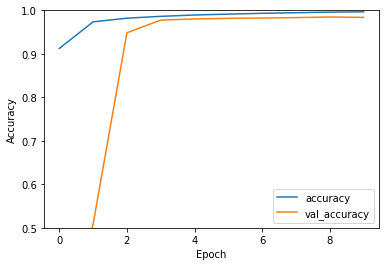

In [119]:
# Evaluate the model
# The gap of accuracy between train and validation is very narrow so it is good. 
# validation acuuracy starts to decrease from epoch 10 so we can stop on epoch 9 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [124]:
score = model.evaluate(x=X_val, 
                       y=y_val_encode,
                       verbose=0)
print('Validation accuracy:', score[1])

Validation accuracy: 0.9838095307350159


In [126]:
# submit on kaggle to obtain test accuracy
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submission.csv", index=False, header=True)

- Test accuracy is 0.98614 which is good as it is higher than training and validation accuracy(training is not overfitted)